In [1]:
%reset

### data for traning

In [4]:
import scipy.io
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from torch.utils.data import DataLoader, sampler,TensorDataset
from itertools import chain
from sklearn.metrics import roc_auc_score, accuracy_score
import os
import torch
import torch.nn as nn
from torch.autograd import Variable

/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mat = scipy.io.loadmat('data_031022_A431_mwell_adhesion_ordered.mat')

In [6]:
print('The file contains:', mat.keys())
print('Count of wavanumber:', len(mat['wavnum'][0]))
print('The wavanumber:', mat['wavnum'][0])
# The first 41 spectra correspond to t=1 to t=41 for well 1 etc.
# For this particular experiment, the different wells were used for different surface coatings: 
# wells 1-4: uncoated, wells 5-8: FBS coated, wells 9-12: fibronectin coated, and wells 13-16: poly-D-lysine coated.

The file contains: dict_keys(['__header__', '__version__', '__globals__', 'data_d0abs_031022_adhesion_ordered', 'data_d2abs_031022_adhesion_ordered', 'wavnum'])
Count of wavanumber: 1200
The wavanumber: [3612.20117605 3610.27261162 3608.34404719 ... 1155.21009314 1153.28152871
 1151.35296428]


In [5]:
# visualise data
#X_i = pd.DataFrame(mat['data_d0abs_031022_adhesion_ordered'])
#X_i.plot(legend=False)

In [6]:
# could apply noise to augment data

### apply PCA on global time series data

In [7]:
# a draw of picture here

In [7]:
X_0 = pd.DataFrame(mat['data_d0abs_031022_adhesion_ordered'])
X_0.columns = mat['wavnum'][0]
print('The raw matrix is', X_0.shape)

The raw matrix is (656, 1200)


In [8]:
print("plasmonic resonance ", range(int((1200-(2231-1151)//2.05)),int((1200-(1845-1151)//2.05))))
print("protein ", range(int((1200-(1807-1151)//2.05)),int((1200-(1498-1151)//2.05))))
print("lipid", range(int((1200-(3064-1151)//2.05)),int((1200-(2756-1151)//2.05))))
#print("tricarbonyl", range((1200-(3064-1151)//2.05),(1200-(2756-1151)//2.05)))

plasmonic resonance  range(674, 862)
protein  range(880, 1031)
lipid range(267, 418)


In [9]:
from sklearn.preprocessing import StandardScaler

In [107]:
def get_loadings(X_0, rang=range(880,1031)):

    sc = StandardScaler()
    X_0 = pd.DataFrame(sc.fit_transform(X_0))

    # input is range of the spectral window
    indices = list(chain(rang))
    x01 = X_0.iloc[:, indices]
    # subset of rows
    # row_idx = list(chain(range(0,41), range(164,205), range(328,369), range(492,533)))
    # row_idx = list(chain(range(0,41)))
    # x011 = x01.iloc[row_idx,:]
    x011 = x01


    # run PCA
    Sum_Explained_variance =.99
    pca = PCA(Sum_Explained_variance)
#     N_Compents = 5
#     pca = PCA(n_components=N_Compents)
    X_i = x011
    X2_data =pca.fit_transform(X_i)
    N_Compents=pca.n_components_ 
#     print(X2_data.shape)
#     print(N_Compents)
    
    #print
    explained_variance = pca.explained_variance_ratio_
    print("explained_variance", explained_variance)
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings = pd.DataFrame(loadings)
    print('loadings:',loadings.shape,'explained_variance_:', pca.explained_variance_.shape)
    
    return loadings, x01, N_Compents

In [108]:
protein_loadings, x01_proteins, N_Compents_proteins = get_loadings(X_0, rang=range(880,1031))
# protein_loadings, x01_proteins, N_Compents_proteins = get_loadings(X_0, rang=range(0,1200))

/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


explained_variance [0.52185965 0.29827416 0.15627741 0.00822575 0.00699619]
loadings: (151, 5) explained_variance_: (5,)


Here, we subselect the protein window, and all categories of whole time series t1-t41 for PCA


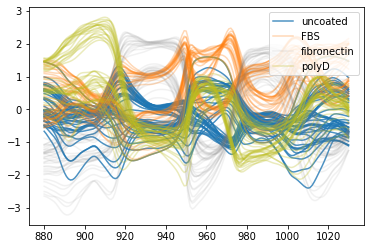

In [109]:
print('Here, we subselect the protein window, and all categories of whole time series t1-t41 for PCA')
plt.plot(x01_proteins.iloc[0:41,:].T,color='C0',alpha=0.8,label='uncoated')
plt.plot(x01_proteins.iloc[164:205,:].T,color='C1',alpha=0.3,label='FBS')
plt.plot(x01_proteins.iloc[328:369,:].T,color='C7',alpha=0.1,label='fibronectin')
plt.plot(x01_proteins.iloc[492:533,:].T,color='C8',alpha=0.3,label='polyD')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(list(np.array(handles)[[0,41,82,133]]), list(np.array(labels)[[0,41,82,133]]), loc='upper right')
plt.show()

In [110]:
lipid_loadings, x01_lipids, N_Compents_lipids = get_loadings(X_0, rang=range(267, 418))

explained_variance [0.70767096 0.24093289 0.03209174 0.01376421]
loadings: (151, 4) explained_variance_: (4,)


/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [111]:
plasmonic_loadings, x01_plasmonic, N_Compents_plasmonic = get_loadings(X_0, rang=range(674, 862))

/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


explained_variance [0.94657657 0.0487867 ]
loadings: (188, 2) explained_variance_: (2,)


/Users/chengqi_xu/.conda/envs/synergyy/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


### arrange the multi-temporal-spectral data for inputting into the LSTM

In [112]:
def get_objectwise(X_uncoated, loadings):
    
    X_uncoated.columns = range(len(loadings))
    X_j = X_uncoated.dot(loadings)
    n = 41  #chunk row size
    list_df_j = [X_j[i:i+n].T for i in range(0,X_j.shape[0],n)]
    return list_df_j

def get_projections(x01=x01_proteins,loadings=protein_loadings):
    n = 41*4  #chunk row size
    list_df = [x01[i:i+n] for i in range(0,x01.shape[0],n)]
    #projected along the PC loadings by matrix multiplication 
    X_uncoated = list_df[0]
    X_FBS = list_df[1]
    X_fibro = list_df[2]
    X_polyD = list_df[3]
    
    list_objs = []
    for _ in [X_uncoated, X_FBS, X_fibro, X_polyD]:
        list_df_j = get_objectwise(_, loadings = loadings)
        list_objs.append(list_df_j)
        
    return list_objs

In [113]:
list_objs_proteins = get_projections(x01=x01_proteins,loadings=protein_loadings)

In [114]:
list_objs_lipids = get_projections(x01=x01_lipids,loadings=lipid_loadings)

In [115]:
list_objs_plasonic= get_projections(x01=x01_plasmonic,loadings=plasmonic_loadings)

### traning process

The structure of the LSTM network consists of a sequence input layer, followed by a blocks containing a long short-term memory (LSTM) layer and a dropout layer, a fully connected (FC) layer, a softmax layer and finally an output layer

In [116]:
def as_torch(list_objs,N_Compents,name):
    dataX = Variable(torch.Tensor(np.array(list_objs)))
    #flatten 4 category *  4 replicates
    PC = N_Compents
    shape = (4, 4, PC, 41)
    dataX = dataX.view(tuple((-1, *shape[2:])))
    print("inputs_{}_windows: ".format(name), dataX.shape)
    
    return dataX

In [117]:
dataX_proteins = as_torch(list_objs_proteins, N_Compents=N_Compents_proteins, name="proteins")
dataX_lipids= as_torch(list_objs_lipids, N_Compents=N_Compents_lipids, name="lipids")
dataX_plasmonic= as_torch(list_objs_plasonic, N_Compents=N_Compents_plasmonic, name="plasmonic")

inputs_proteins_windows:  torch.Size([16, 5, 41])
inputs_lipids_windows:  torch.Size([16, 4, 41])
inputs_plasmonic_windows:  torch.Size([16, 2, 41])


In [118]:
# concatenate the tensors along PCs

In [146]:
dataX = torch.cat([dataX_proteins, dataX_lipids], dim=1)
# dataX = torch.cat([dataX_proteins], dim=1)
dataX.shape

torch.Size([16, 9, 41])

In [147]:
y = np.array([[0,1,2,3]])
y = np.repeat(y, 4)
dataY = Variable(torch.Tensor(np.array(y))).view(16,1)
print("targets ", dataY.shape)

targets  torch.Size([16, 1])


### LSTM

In [148]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # dropout & biLSTM
        #, bidirectional=True
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Sequential(
            nn.Linear(self.hidden_size, num_classes),          
            nn.Sigmoid()
        )

    def forward(self, x):
        In_Lstm = x
        # In_Lstm = torch.reshape(In_Lstm,(-1,1,self.input_size))
        # In_Lstm--> (batch, seq_len=1, input_size) as batch first;
        h0 = torch.zeros(self.num_layers, In_Lstm.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, In_Lstm.size(0), self.hidden_size)
        # h0, c0 --> (num_layers, batch_size, hidden_size)
        ula, (h_out, _) = self.lstm(In_Lstm,(h0, c0))
        # out --> (batch_size, sequence_len, hidden_size)
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)

        return out

In [176]:
# Configuration options
print(dataX.shape)
input_size = dataX.shape[1] #Number of features used as input. (Number of columns)
hidden_size = 20 #time
num_layers = 1
num_classes = 4
num_epochs = 50
batch_size = 4

learning_rate = 5e-3

model = LSTM(num_classes, input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

model

torch.Size([16, 9, 41])


LSTM(
  (lstm): LSTM(9, 20, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=20, out_features=4, bias=True)
    (1): Sigmoid()
  )
)

In [177]:
#Configurations on k folds
k_folds = 4
#dataX.permute(0, 2, 1)
whole_dataset = torch.utils.data.TensorDataset(*[dataX.permute(0, 2, 1), dataY])

# Define the K-fold Cross Validator
# kfold = KFold(n_splits=k_folds, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(whole_dataset,dataY)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = DataLoader(whole_dataset, batch_size=batch_size, sampler=train_subsampler)
    valloader = DataLoader(whole_dataset,batch_size=batch_size, sampler=test_subsampler)

    # init para for each fold  
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    # Train the model
    results = {}
    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        train_correct = 0
        for i, (inputs, target) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            #get prediction
            output = model(inputs)
            output_idx = output.max(1, keepdim=True)[1]  # get the index of the max logit
            target = target.type(torch.LongTensor)
            # obtain the loss function
            loss = criterion(output, target.squeeze())
            #backward
            loss.backward()
            optimizer.step()

            train_correct += torch.sum(output_idx==target)
            train_loss.append(loss.detach()/batch_size)

        if epoch%10==0:
            print("train loss", np.round(np.mean(train_loss),5), "train accuracy {}/{}".format(np.round(train_correct).numpy(),len(target)*(k_folds-1)))

        results[epoch] = np.round(np.mean(train_loss))

        # Saving the best model
        if results[epoch] <= min(results.values()):
            save_path = os.path.join('best_model_%s.pth' % 'lstm')
            torch.save(model.state_dict(), save_path)
            model_weigths = model.state_dict()
            
    # validation
    model.eval()
    model.load_state_dict(model_weigths)
    val_correct = 0.0
    actuals = []
    predicts = []
    with torch.no_grad():
        for i, (data, ts) in enumerate(valloader, 0):
            pred = model(data)
            zs = pred.max(1, keepdim=True)[1]
            val_correct += torch.sum(zs==ts)
            actuals.append(ts.squeeze())
            predicts.append(zs.squeeze())
            
    actuals = [val for sublist in np.vstack(list(chain(*actuals))) for val in sublist]
    predicts = [val for sublist in np.vstack(list(chain(*predicts))) for val in sublist]

    print("validation accuracy {}/{}".format(np.round(val_correct).numpy(), len(actuals)), "predicts: ", predicts, "labels: ", actuals)

    #     print(f'Epoch {epoch}/{num_epochs} ---train loss {np.round(np.mean(train_loss),5))})
    #         --- val correct {np.round(val_correct)})

--------------------------------
FOLD 0
--------------------------------
train loss 0.3435 train accuracy 1/12
train loss 0.27888 train accuracy 12/12
train loss 0.23799 train accuracy 12/12
train loss 0.21985 train accuracy 12/12
train loss 0.21 train accuracy 12/12
validation accuracy 4.0/4 predicts:  [0, 2, 1, 3] labels:  [0.0, 2.0, 1.0, 3.0]
FOLD 1
--------------------------------
train loss 0.35894 train accuracy 1/12
train loss 0.26679 train accuracy 12/12
train loss 0.2285 train accuracy 12/12
train loss 0.21496 train accuracy 12/12
train loss 0.20663 train accuracy 12/12
validation accuracy 4.0/4 predicts:  [2, 3, 0, 1] labels:  [2.0, 3.0, 0.0, 1.0]
FOLD 2
--------------------------------
train loss 0.34406 train accuracy 4/12
train loss 0.26724 train accuracy 11/12
train loss 0.23888 train accuracy 11/12
train loss 0.22527 train accuracy 12/12
train loss 0.21699 train accuracy 12/12
validation accuracy 4.0/4 predicts:  [2, 3, 1, 0] labels:  [2.0, 3.0, 1.0, 0.0]
FOLD 3
--------

In [178]:
# rnn = nn.LSTM(input_size=9, hidden_size=3, batch_first=True,num_layers=1)
# input = torch.randn(4,41,9)
# h0 = torch.randn(1, 4, 3)
# c0 = torch.randn(1, 4, 3)
# output, (hn, cn) = rnn(input, (h0, c0))
# hn.view(-1, 3)
